
     -----------------------------------------------------------------------------------------
     -----------------------------------------------------------------------------------------
                                1 Dimensional SPH Code
     -----------------------------------------------------------------------------------------
     Starting date: November 2023
     Last edit date: 2024-06-18
     Author: Pratishtha Rawat (University of Warwick)
     -----------------------------------------------------------------------------------------
     -----------------------------------------------------------------------------------------


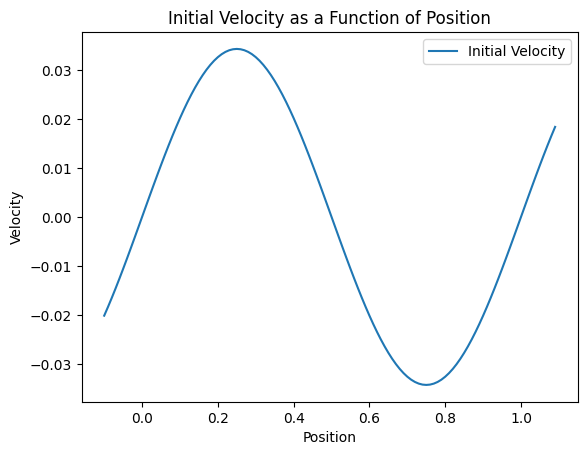

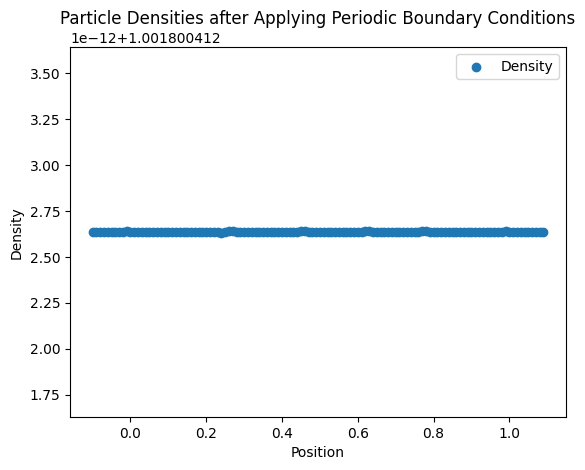

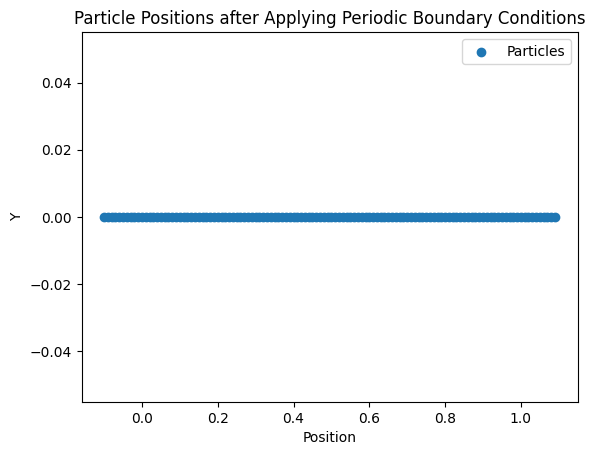

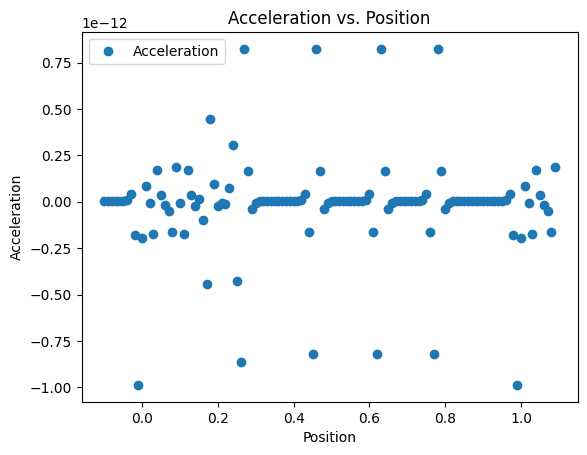

CFL condition satisfied, proceeding with timestepping
Execution time: 281.13 seconds


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from particle_system_pandas import SPHParticles
from density_pandas import get_density, get_accel
from equation_of_state_pandas import equation_of_state
from output_pandas import output_particles
import boundary_conditions_pandas as bc
import output_pandas as output
from derivs import derivs
from timestepping import leapfrog_integration
from cfl_condition import compute_cfl_time_step

def main():
    start_time = time.time()
    current_time = 0.0

    #Initialize a bunch of stuff 
    
    #Simulation parameters
    sound_speed = 1.0
    n_particles = 100
    num_neighbors = 10
    xmin_value = 0.0
    xmax_value = 1.0
    rho_0_value = 1.0
    
    
    #Output related
    output_filename = "sph_initial.txt"
    tout = 0.05  # Specify the time between output files here
    next_output_time = tout
    output_index = 1

    total_particles = n_particles + 2 * num_neighbors
    particles = SPHParticles(total_particles)

    particles.setup(xmin_value, xmax_value, rho_0_value, num_neighbors)

    #since mass of particles is dictated by rho_0 and number of particles, it is not here as an input value but it is same for all particles
    mass = particles.mass
    
    output_particles(particles.to_dataframe(), output_filename)

    data = pd.read_csv(output_filename)
    position = data['Position']
    velocity = data['Velocity']

    output.print_header()
    
    plt.plot(position, velocity, label='Initial Velocity')
    plt.title('Initial Velocity as a Function of Position')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.legend()
    plt.show()

    particles = derivs(particles, mass, num_neighbors, sound_speed)

    #output_filename = f"sph{output_index}.txt"
    #output_particles(particles.to_dataframe(), output_filename)
    #output_index += 1

    plt.scatter(particles.data['Position'], particles.data['Density'], label='Density')
    plt.title('Particle Densities after Applying Periodic Boundary Conditions')
    plt.xlabel('Position')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    plt.scatter(particles.data['Position'], [0] * len(particles.data['Position']), label='Particles')
    plt.title('Particle Positions after Applying Periodic Boundary Conditions')
    plt.xlabel('Position')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

    plt.plot(particles.data['Position'], particles.data['Acceleration'], 'o', label='Acceleration')
    plt.xlabel('Position')
    plt.ylabel('Acceleration')
    plt.title('Acceleration vs. Position')
    plt.legend()
    plt.show()

    #print("Length of df", len(particles.data['Position']))
    #print(particles.data['Acceleration'].tolist())

    # Initialize parameters for CFL condition
    C = 0.3  # Adjust as needed
    h = particles.data['Smoothing_Length']  # Assuming you have a method to get the smoothing length
    vmax = np.max(np.abs(particles.data['Velocity']))  # Maximum velocity in the domain
    csmax = sound_speed 
    
    dt = 0.003  # Check for this timestep with Bec
    end_simulation_time = 5.0  # adjust this value for the total simulation time

    max_files = int(end_simulation_time / tout) + 1
    padding_width = len(str(max_files))

    cfl_dt = compute_cfl_time_step(C, h, vmax, csmax).iloc[0]
    if dt > cfl_dt:
        raise ValueError(f"Time step dt = {dt} violates CFL condition. Adjust simulation parameters or decrease dt. The CFL condition requires dt < {cfl_dt}")
    if dt <= cfl_dt:
        print("CFL condition satisfied, proceeding with timestepping")
            
    while current_time < end_simulation_time:
        
        leapfrog_integration(particles, dt, mass, num_neighbors, sound_speed)
        current_time += dt

        if current_time >= next_output_time:
            output_filename = f"sph_testsim{output_index:0{padding_width}d}.txt"
            output_particles(particles.to_dataframe(), output_filename)
            output_index += 1
            next_output_time += tout
            
    end_time = time.time()
    output.print_execution_time(start_time, end_time)

if __name__ == "__main__":
    main()
